In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

**os**는 파이썬 내장 모듈로, 운영체제와 상호 작용하기 위한 함수들을 제공합니다. 파일 및 디렉토리 조작, 환경 변수 액세스, 프로세스 관리 등 다양한 작업을 수행할 수 있습니다. <br/>
<br/>
**re**는 정규 표현식(regular expression)을 다루기 위한 파이썬 내장 모듈입니다. 정규 표현식은 문자열의 패턴을 정의하고, 이를 기반으로 검색, 대체, 분할 등의 작업을 수행할 수 있습니다. <br/>
<br/>
**shutil**은 파일 및 디렉토리 작업을 위한 파이썬 내장 모듈입니다. 파일 복사, 이동, 이름 변경 등과 같은 일반적인 파일 및 디렉토리 조작 작업을 쉽게 수행할 수 있는 함수들을 제공합니다. <br/>
<br/>
**string**은 파이썬 내장 모듈로, 문자열과 관련된 유틸리티 함수와 상수들을 제공합니다. 문자열의 대소문자 변환, 특정 문자 제거, 포맷팅 등의 작업을 수행할 수 있습니다.

In [2]:
print(tf.__version__)

2.12.0


# 1. 감정 분석
리뷰 텍스트를 사용하여 영화 리뷰를 긍정적 또는 부정적으로 분류합니다.

## 1-1. 데이터세트 다운로드 및 탐색하기

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar = True, cache_dir = '.',
                                  cache_subdir = '')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 88s 1us/step


**tf.keras.utils.get_file**함수는 지정된 URL에서 파일을 다운로드하고, 로컬 시스템에 저장한 후 파일 경로를 반환합니다. 주어진 URL로부터 파일을 다운로드하고 압축을 해제하는 기능을 제공합니다. <br/>
<br/>
**untar**은 압축 파일을 해제할 것인지 여부를 지정합니다. <br/>
<br/>
**cache_dir**은 다운로드한 파일을 저장할 디렉토리 경로를 지정합니다. 현재 디렉토리를 의미하는 '.'으로 설정되었습니다. <br/>
<br/>
**cache_subdir**은 다운로드한 파일을 저장할 하위 디렉토리 이름을 지정합니다.

In [5]:
# 지정된 디렉토리 내 파일과 하위 디렉토리의 리스트를 반환
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## 1-2. 데이터세트 로드하기

In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

**shutil.rmtree**는 지정된 디렉토리와 해당 디렉토리의 모든 하위 디렉토리 및 파일을 재귀적으로 삭제하는 기능을 제공합니다.

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size, # 데이터셋의 배치 크기
    validation_split = 0.2, # 검증 데이터로 분할하는 비율
    subset = 'training', # 훈련 데이터 생성
    seed = seed # 데이터 분할에 사용되는 시드값
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


## 1-3. 훈련을 위한 데이터세트 준비하기
유용한 **tf.keras.layers.TextVectorization** 레이어를 사용하여 데이터를 표준화, 토큰화 및 벡터화합니다. <br/>
<br/>
표준화는 일반적으로 구두점이나 HTML 요소를 제거하여 데이터세트를 단순화하기 위해 텍스트를 전처리하는 것을 말합니다. 토큰화는 문자열을 여러 토큰으로 분할하는 것을 말합니다. 벡터화는 토큰을 숫자로 변환하여 신경망에 공급될 수 있도록 하는 것을 말합니다. 이러한 모든 작업을 이 레이어에서 수행할 수 있습니다.

In [14]:
# 사용자 정의 전처리 함수
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data) # 입력 데이터의 모든 문자를 소문자로 변환
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # HTML 태그 제거
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '') # 정규 표현식을 사용하여 문장부호를 제거

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features, # 생성될 토큰의 최대 개수 지정
    output_mode = 'int', # 정수로 인코딩된 벡터가 생성됩니다.
    output_sequence_length = sequence_length # 벡터의 길이를 지정합니다.
)

이 레이어를 사용하여 데이터를 표준화, 토큰화 및 벡터화합니다. 각 토큰에 대해 고유한 정수 인덱스를 생성하도록 **output_mode**를 int로 설정합니다.

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
# 전처리한 결과를 확인하는 함수
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [18]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [19]:
# 각 정수에 해당하는 토큰(문자열)을 조회
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


**vectorize_layer.get_vocabulary**는 **TextVectorization** 레이어의 단어장을 반환합니다. 이 단어장은 각 토큰(단어)에 대해 정수 인덱스를 매핑한 딕셔너리 형태입니다.

In [20]:
# 이전에 생성한 TextVectorization 레이어를 훈련, 검증 및 테스트 데이터세트에 적용
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## 1-4. 성능을 높이도록 데이터세트 구성
I/O가 차단되지 않도록 데이터를 로드할 때 사용해야 하는 두 가지 중요한 메소드. <br/>
- .cache()는 데이터가 디스크에서 로드된 후 메모리에 데이터를 보관합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트로 인해 병목 현상이 발생하지 않습니다.
- .prefetch()는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

In [25]:
# 데이터셋 API 사용 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE # 데이터를 자동으로 조정

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE) # buffer_size: 미리 로드할 데이터의 개수 지정
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

## 1-5. 모델 생성
신경망을 만들 차례입니다.

In [26]:
embedding_dim = 16

In [27]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim), # 단어를 밀집 벡터로 변환하는 역할
    layers.Dropout(0.2), # 과적합을 방지하기 위해 입력 유닛의 일부를 무작위로 꺼주는 역할
    layers.GlobalAveragePooling1D(), # 고정된 길이의 출력을 생성
    layers.Dropout(0.2),
    layers.Dense(1) # 완전 연결층을 의미, 1개의 출력 뉴런을 가지는 밀집 층 생성
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

층을 순서대로 쌓아 분류기(classifier)를 만듭니다: <br/>
- 첫 번째 레이어는 **Embedding** 레이어입니다. 이 레이어는 정수로 인코딩된 리뷰를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이러한 벡터는 모델이 훈련되면서 학습됩니다. 이들 벡터는 출력 배열에 차원을 추가합니다. 최종 차원은 (batch, sequence, embedding)이 됩니다.
- **GlobalAveragePooling1D**층은 **sequence** 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 길이가 다른 입력을 다루는 가장 간단한 방법입니다.
- 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결층을 거칩니다.
- 마지막 층은 하나의 출력 노드(node)를 가진 완전 연결층입니다. **sigmoid** 활성화 함수를 사용하여 0과 1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다.

## 1-6. 손실 함수와 옵티마이저
모델을 훈련하려면 손실 함수와 옵티마이저가 필요합니다.

In [29]:
model.compile(loss = losses.BinaryCrossentropy(from_logits = True),
              optimizer = 'adam', # 효율적인 경사 하강법 알고리즘 중 하나
              metrics = tf.metrics.BinaryAccuracy(threshold = 0.0)) # 모델의 출력이 0.0보타 크면 예측을 1

## 1-7. 모델 훈련하기

In [30]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
625/625 [==============================] - 19s 29ms/step - loss: 0.6656 - binary_accuracy: 0.6928 - val_loss: 0.6173 - val_binary_accuracy: 0.7700
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5512 - binary_accuracy: 0.7990 - val_loss: 0.5004 - val_binary_accuracy: 0.8216
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4467 - binary_accuracy: 0.8457 - val_loss: 0.4214 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 3s 6ms/step - loss: 0.3796 - binary_accuracy: 0.8646 - val_loss: 0.3748 - val_binary_accuracy: 0.8602
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3366 - binary_accuracy: 0.8774 - val_loss: 0.3457 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3055 - binary_accuracy: 0.8881 - val_loss: 0.3265 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

## 1-7. 모델 평가하기

In [31]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 59s 75ms/step - loss: 0.3102 - binary_accuracy: 0.8739
Loss:  0.3102398216724396
Accuracy:  0.8738800287246704


## 1-8. 정확도와 손실 그래프 그리기

In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

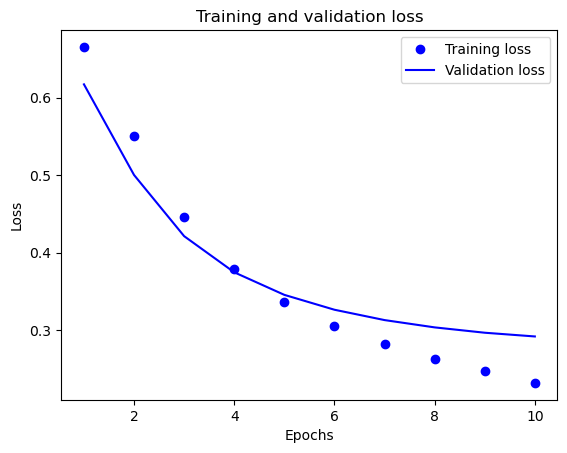

In [33]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label = 'Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

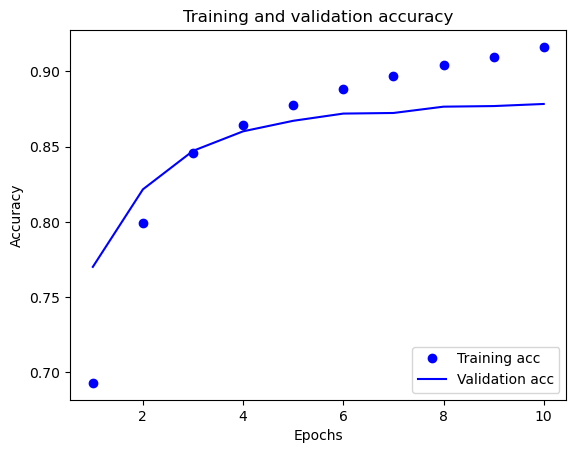

In [34]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

이 그래프에서 점선은 훈련 손실과 훈련 정확도를 나타냅니다. 실선은 검증 손실과 검증 정확도입니다. <br/>
<br/>
훈련 손실은 각 epoch마다 감소하고 훈련 정확성은 각 epoch마다 증가합니다. 경사 하강 최적화를 사용할 때 이와 같이 예상됩니다. 모든 반복에서 원하는 수량을 최소화해야 합니다. <br/>
<br/>
하지만 검증 손실과 검증 정확도는 아닙니다. 훈련 정확도 이전이 피크인 것 같습니다. 이는 과대적합 때문입니다. 이전에 본 적없는 데이터보다 훈련 데이터에서 모델이 더 잘 동작합니다. 이 지점부터는 모델이 과도하게 최적화되어 테스트 데이터에서 일반화되지 않는 특정 표현을 학습합니다.

# 2. 모델 내보내기
방금 훈련한 가중치를 사용하여 새 모델을 만들 수 있습니다.

In [35]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss = losses.BinaryCrossentropy(from_logits = False), optimizer = "adam", metrics = ['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3102 - accuracy: 0.8739
0.8738800287246704


## 5-2. 새로운 데이터 추론하기

In [36]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 161ms/step


array([[0.6153428 ],
       [0.4355315 ],
       [0.35372308]], dtype=float32)